In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import glob
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mass_spec_utils

In [8]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

Running standards. First of all, we need to be able to read the new mzML file or csv file. Let's try first with the mzML file.

In [26]:
new_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/Positive/Standards/Std1_1_23Oct18.mzML"
old_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/Positive/Standards/Std1_2_23Oct18.mzML"

Next, we need to extract the standards from inside the new_mzml file.
In order to do this, I quess I will use the method Simon suggested, i.e. choose m/z with highest intensities
(search for method in his code). 

In [24]:
from mass_spec_utils.data_import.mzml import MZMLFile

In [28]:
new_mzml = MZMLFile(new_mzml_file)
old_mzml = MZMLFile(old_mzml_file)

Loaded 1185 scans
Loaded 1192 scans


Next, extract the standards from inside the old_mzml file in the same way as above.

In [53]:
standards_list_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/standards_list.csv"
standards = pd.read_csv(standards_list_file)

In [54]:
sys.path.append("../")
import metab_utils

In [89]:
standards_list = metab_utils.create_std_dict_by_mz(standards, polarity = '+')

In [99]:
new_mzml_rts = []
old_mzml_rts = []
ppm = 0.1
for mz in standards_list:
    new_rt = new_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm)[1]
    new_mzml_rts.append(new_rt/60)
    old_rt = old_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm)[1]
    old_mzml_rts.append(old_rt/60)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [138]:
from metab_utils import return_data_with_no_outliers
new_mzml_rts_mod, old_mzml_rts_mod = return_data_with_no_outliers(new_mzml_rts, old_mzml_rts, np.subtract(new_mzml_rts,old_mzml_rts), 1)

print("Choosing the optimal kernel...")
from metab_utils import try_gp_regressions
model, kernel, results = try_gp_regressions(np.array(new_mzml_rts_mod), np.array(old_mzml_rts_mod)-np.array(new_mzml_rts_mod))

Choosing the optimal kernel...
Cross-Predicted Accuracy for RBF : -0.02374298407141029
Mean absolute error for RBF : 0.023185903893535344
Mean squared error for RBF : 0.0008304628192384405
Cross-Predicted Accuracy for MLP : -0.023731728941047914
Mean absolute error for MLP : 0.023185817730390537
Mean squared error for MLP : 0.0008304536890490891


 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Cross-Predicted Accuracy for MLP+RBF : 0.0006497385495928265
Mean absolute error for MLP+RBF : 0.023448190464706066
Mean squared error for MLP+RBF : 0.00081067538282918
Cross-Predicted Accuracy for MLP*RBF : 0.19930708724168245
Mean absolute error for MLP*RBF : 0.022213923876467787
Mean squared error for MLP*RBF : 0.0006495240543959892
Cross-Predicted Accuracy for Cosine*RBF : 0.17520470570321045
Mean absolute error for Cosine*RBF : 0.02241888562213524
Mean squared error for Cosine*RBF : 0.000669075965407087
Cross-Predicted Accuracy for Cosine+RBF : -0.023742995522954224
Mean absolute error for Cosine+RBF : 0.023185903221073945
Mean squared error for Cosine+RBF : 0.000830462828527961
Final kernel: MLP*RBF


  mul.                 |                  value  |  constraints  |  priors
  mlp.variance         |    0.00859869660799844  |      +ve      |        
  mlp.weight_variance  |    0.08449223528336045  |      +ve      |        
  mlp.bias_variance    |  3.842095366246017e-06  |      +ve      |        
  rbf.variance         |     0.2163663945107785  |      +ve      |        
  rbf.lengthscale      |      4.817996008776943  |      +ve      |        
Optimization restart 1/10, f = -95.4689809652259
Optimization restart 2/10, f = -95.4689788678081
Optimization restart 3/10, f = -95.46898102327347
Optimization restart 4/10, f = -95.46898021160862
Optimization restart 5/10, f = -95.46898099331186
Optimization restart 6/10, f = -95.46897850025124
Optimization restart 7/10, f = -95.46898114570247
Optimization restart 8/10, f = -95.46897832427607
Optimization restart 9/10, f = -95.46898122079565
Optimization restart 10/10, f = -95.46898130706933


{'dataplot': [<matplotlib.collections.PathCollection at 0x115345700>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x115345ee0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x11d4f38e0>]}

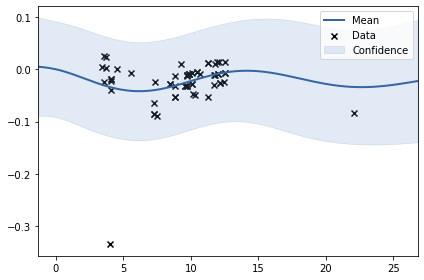

In [122]:
model.optimize_restarts(10)
print(model.parameters[0])
model.plot()

From Simon: Write a method which takest a list of m/z values (of the standards), ppm tolerances, RT-ranges and then two files, and it finds the position of each standard (defined as the highest intensity in the RT_range and mz tolerance and then learns a regression function

Create method encapsulating the code in this notebook.

In [141]:
def get_gp_for_new_file(new_mzml_file, old_mzml_file, standards_list, mz_ppm = 0.1, zscore = 1):
    from mass_spec_utils.data_import.mzml import MZMLFile
    print("Creating MZMLFile objects...")
    new_mzml = MZMLFile(new_mzml_file)
    old_mzml = MZMLFile(old_mzml_file)
    
    new_mzml_rts = []
    old_mzml_rts = []
   
    for mz in standards_list:
        new_rt = new_mzml.get_max_intensity(mz_min = mz - mz_ppm , mz_max = mz + mz_ppm)[1]
        new_mzml_rts.append(new_rt/60)
        old_rt = old_mzml.get_max_intensity(mz_min = mz - mz_ppm , mz_max = mz + mz_ppm)[1]
        old_mzml_rts.append(old_rt/60)
        
    from metab_utils import return_data_with_no_outliers
    new_mzml_rts_mod, old_mzml_rts_mod = return_data_with_no_outliers(new_mzml_rts, old_mzml_rts, np.subtract(new_mzml_rts,old_mzml_rts), zscore)
    
    print("Choosing the optimal kernel")
    from metab_utils import try_gp_regressions
    model, kernel, results = try_gp_regressions(np.array(new_mzml_rts_mod), np.array(old_mzml_rts_mod)-np.array(new_mzml_rts_mod))
    
    model.optimize_restarts(10)
    print("Kernel hyperparameters:",model.parameters[0])
    model.plot()

Creating MZMLFile objects...
Loaded 1185 scans
Loaded 1192 scans
Choosing the optimal kernel
Cross-Predicted Accuracy for RBF : -0.02374298407141029
Mean absolute error for RBF : 0.023185903893535344
Mean squared error for RBF : 0.0008304628192384405
Cross-Predicted Accuracy for MLP : -0.023731728941047914
Mean absolute error for MLP : 0.023185817730390537
Mean squared error for MLP : 0.0008304536890490891


 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Cross-Predicted Accuracy for MLP+RBF : 0.0006497385495928265
Mean absolute error for MLP+RBF : 0.023448190464706066
Mean squared error for MLP+RBF : 0.00081067538282918
Cross-Predicted Accuracy for MLP*RBF : 0.19930708724168245
Mean absolute error for MLP*RBF : 0.022213923876467787
Mean squared error for MLP*RBF : 0.0006495240543959892
Cross-Predicted Accuracy for Cosine*RBF : 0.17520470570321045
Mean absolute error for Cosine*RBF : 0.02241888562213524
Mean squared error for Cosine*RBF : 0.000669075965407087
Cross-Predicted Accuracy for Cosine+RBF : -0.023742995522954224
Mean absolute error for Cosine+RBF : 0.023185903221073945
Mean squared error for Cosine+RBF : 0.000830462828527961
Final kernel: MLP*RBF
Optimization restart 1/10, f = -95.4689809652259
Optimization restart 2/10, f = -95.46898110449027
Optimization restart 3/10, f = -95.46898136122059
Optimization restart 4/10, f = -95.46898113473549
Optimization restart 5/10, f = -95.46897577041662
Optimization restart 6/10, f = -95.4

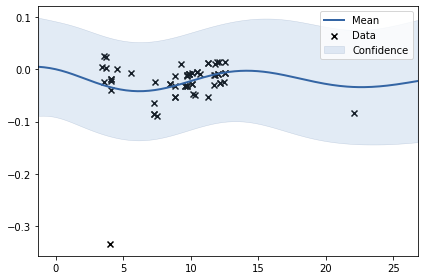

In [142]:
get_gp_for_new_file(new_mzml_file, old_mzml_file, standards_list)

Check fragmentation file

In [131]:
frag_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/FRAG/FRAG_POS.mzML"

In [132]:
frag_mzml = MZMLFile(frag_mzml_file)

Loaded 9657 scans


In [135]:
for mz in standards_list:
    print(standards_list[mz])
    print(frag_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm))
    print("================================")

('melatonin', 257.4, '+', 2046167614)
(233.17469787597656, 213.828558, 320414.59375)
('phenylhydrazine', 288.0, '+', 8384383)
(109.07607095524386, 627.2918400000001, 192844.0813080791)
('nicotinate', 437.4, '+', 593840852)
(123.96447312441632, 410.150082, 1146245.9571218835)
('pyridoxine', 445.79999999999995, '+', 3992986142)
(170.0924530029297, 629.1161999999999, 3514035.25)
('riboflavin', 463.2, '+', 16465628)
(377.1741027832031, 528.035166, 223553.0625)
('adenine', 525.0, '+', 1645830897)
(136.04823303222656, 516.660042, 5259965.5)
('creatinine', 538.8000000000001, '+', 1662180782)
(114.06620788574219, 516.660042, 338174176.0)
('l-phenylalanine', 549.0, '+', 489171784)
(166.0863037109375, 528.035166, 52072224.0)
('l-leucine', 576.5999999999999, '+', 215023034)
(132.07676696777344, 706.69722, 177232240.0)
('inosine', 588.0, '+', 167162672)
(269.0879821777344, 570.508302, 3215549.5)
('2-phenylglycine', 605.4, '+', 110631677)
(152.02218627929688, 514.473042, 710326.75)
('selenomethioni

(184.07341593437522, 192.526074, 56247983.18879289)
('dcmp', 709.2, '+', 426273)
(308.0065612792969, 624.02208, 51016.59375)
('l-2-aminoadipate', 726.0, '+', 4607679)
(162.1124725341797, 642.57858, 145900144.0)
('l-homoserine', 742.8000000000001, '+', 134553196)
(120.08086120666736, 528.305778, 13390014.657666327)
('n-acetylornithine', 737.4, '+', 247009406)
(175.11903381347656, 1132.03002, 20583378.0)
('4-aminobutanoate', 752.4, '+', 205910257)
(104.10697174072266, 1000.1087400000001, 14486916.0)
('l-cystathionine', 795.6, '+', 139185)
(223.09666442871094, 208.94767800000002, 296848.21875)
('choline', 1045.8, '+', 392195944)
(104.10697174072266, 1000.1087400000001, 14486916.0)
('1-aminopropan-2-ol', 1125.0, '+', 24700144)
(76.0757064819336, 558.799806, 2478501.5)
('l-ornithine', 1038.6, '+', 2655807)
(133.08009338378906, 706.69722, 7915752.0)
('taurocholate', 253.8, '+', 2634703)
(516.3385620117188, 205.75790999999998, 111861.5390625)
('lipoate', 265.2, '+', 166523)
(207.1129302978515